In [1]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tueplots import bundles
bundles.icml2024()

from torchmetrics import AUROC
auroc = AUROC(task="binary")

import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(0)

device = "cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

def visualize_response_matrix(results, value, filename):
    # Extract the groups labels in the order of the columns
    group_values = results.columns.get_level_values("scenario")

    # Identify the boundaries where the group changes
    boundaries = []
    for i in range(1, len(group_values)):
        if group_values[i] != group_values[i - 1]:
            boundaries.append(i - 0.5)  # using 0.5 to place the line between columns

    # Visualize the results with a matrix: red is 0, white is -1 and blue is 1
    cmap = mcolors.ListedColormap(["white", "red", "blue"])
    bounds = [-1.5, -0.5, 0.5, 1.5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Calculate midpoints for each group label
    groups_list = list(group_values)
    group_names = []
    group_midpoints = []
    current_group = groups_list[0]
    start_index = 0
    for i, grp in enumerate(groups_list):
        if grp != current_group:
            midpoint = (start_index + i - 1) / 2.0
            group_names.append(current_group)
            group_midpoints.append(midpoint)
            current_group = grp
            start_index = i
    # Add the last group
    midpoint = (start_index + len(groups_list) - 1) / 2.0
    group_names.append(current_group)
    group_midpoints.append(midpoint)

    # Define the minimum spacing between labels (e.g., 100 units)
    min_spacing = 100
    last_label_pos = -float("inf")
    # Plot the matrix
    with plt.rc_context(bundles.icml2024(usetex=True, family="serif")):
        fig, ax = plt.subplots(figsize=(20, 10))
        cax = ax.matshow(value, aspect="auto", cmap=cmap, norm=norm)

        # Add vertical lines at each boundary
        for b in boundaries:
            ax.axvline(x=b, color="black", linewidth=0.25, linestyle="--", alpha=0.5)
        
        # Add group labels above the matrix, only if they're spaced enough apart
        for name, pos in zip(group_names, group_midpoints):
            if pos - last_label_pos >= min_spacing:
                ax.text(pos, -5, name, ha='center', va='bottom', rotation=90, fontsize=3)
                last_label_pos = pos

        # Add model labels on the y-axis
        ax.set_yticks(range(len(results.index)))
        ax.set_yticklabels(results.index, fontsize=3)

        # Add a colorbar
        cbar = plt.colorbar(cax)
        cbar.set_ticks([-1, 0, 1])
        cbar.set_ticklabels(["-1", "0", "1"])
        plt.savefig(filename, dpi=600, bbox_inches="tight")
        plt.close()

def trainer(parameters, optim, closure, n_iter=100, verbose=True):
    pbar = tqdm(range(n_iter)) if verbose else range(n_iter)
    for iteration in pbar:
        if iteration > 0:
            previous_parameters = [p.clone() for p in parameters]
            previous_loss = loss.clone()
        
        loss = optim.step(closure)
        
        if iteration > 0:
            d_loss = (previous_loss - loss).item()
            d_parameters = sum(
                torch.norm(prev - curr, p=2).item()
                for prev, curr in zip(previous_parameters, parameters)
            )
            grad_norm = sum(torch.norm(p.grad, p=2).item() for p in parameters if p.grad is not None)
            if verbose:
                pbar.set_postfix({"grad_norm": grad_norm, "d_parameter": d_parameters, "d_loss": d_loss})
            
            if d_loss < 1e-5 and d_parameters < 1e-5 and grad_norm < 1e-5:
                break
    return parameters

def compute_auc(probs, data, train_idtor, test_idtor):
    train_probs = probs[train_idtor.bool()]
    test_probs = probs[test_idtor.bool()]
    train_labels = data[train_idtor.bool()]
    test_labels = data[test_idtor.bool()]
    train_auc = auroc(train_probs, train_labels)
    test_auc = auroc(test_probs, test_labels)
    print(f"train auc: {train_auc}")
    print(f"test auc: {test_auc}")
    
    return train_auc, test_auc

def compute_cttcorr(probs, data, train_idtor, test_idtor):
    train_probs  = probs.clone()
    test_probs   = probs.clone()
    train_labels = data.clone()
    test_labels  = data.clone()

    train_mask = ~train_idtor.bool()
    train_probs[train_mask]  = float('nan')
    train_labels[train_mask] = float('nan')

    test_mask = ~test_idtor.bool()
    test_probs[test_mask]   = float('nan')
    test_labels[test_mask]  = float('nan')
    
    train_prob_ctt = torch.nanmean(train_probs, dim=1).detach().cpu().numpy()
    train_label_ctt = torch.nanmean(train_labels, dim=1).detach().cpu().numpy()
    train_mask = ~np.isnan(train_prob_ctt) & ~np.isnan(train_label_ctt)
    train_cttcorr = pearsonr(train_prob_ctt[train_mask], train_label_ctt[train_mask]).statistic
    
    test_prob_ctt = torch.nanmean(test_probs, dim=1).detach().cpu().numpy()
    test_label_ctt = torch.nanmean(test_labels, dim=1).detach().cpu().numpy()
    test_mask = ~np.isnan(test_prob_ctt) & ~np.isnan(test_label_ctt)
    test_cttcorr = pearsonr(test_prob_ctt[test_mask], test_label_ctt[test_mask]).statistic
    
    print(f"train cttcorr: {train_cttcorr}")
    print(f"test cttcorr: {test_cttcorr}")

    return train_cttcorr, test_cttcorr

In [2]:
master_test_df = pd.read_csv("../data/master_test_metadata.csv")
final_test_data_matrix = pd.read_pickle("../data/master_test_data_matrix.pkl").values
dtype = torch.float64 if device.startswith("cuda") else torch.float32
final_test_data_matrix = np.nan_to_num(final_test_data_matrix, nan=0)

In [3]:
import torch
import pandas as pd
import numpy as np
from torch.distributions import Bernoulli
from torch.optim import LBFGS
from tqdm import tqdm
import pingouin as pg
import gc

# Assume 'trainer' function is defined
# Assume 'device' is set (e.g., 'cuda' or 'cpu')

# ====================================================================================
# 1. SETUP FOR THE MASTER TEST
# ====================================================================================

# <<< Use the data for the new 120-item MASTER TEST >>>
data_with0 = torch.tensor(final_test_data_matrix, device=device, dtype=torch.float32)
n_test_takers, n_items = data_with0.shape
n_dimensions = 6 # Your test has 6 dimensions (PC2 through PC7)

# <<< Build the 6-Dimension Q-Matrix from your master_test_df >>>
print("--- Building 6-Dimension Q-Matrix ---")
# Get the unique component names in the correct order
component_names = master_test_df['component'].unique()
# Use pandas get_dummies to one-hot encode the 'component' column
Q_matrix_df = pd.get_dummies(master_test_df['component'])
# Ensure the columns are in the same order as your components
Q_matrix_df = Q_matrix_df[component_names]
# Convert to a torch tensor
Q_matrix = torch.tensor(Q_matrix_df.values, device=device, dtype=torch.float32)

print(f"MASTER TEST specs: {n_test_takers} takers, {n_items} items, {n_dimensions} dimensions.")
print(f"Shape of new Q-Matrix: {Q_matrix.shape}")


# ====================================================================================
# 2. FIT THE 6-DIMENSION MIRT MODEL
# ====================================================================================
data_idtor = torch.ones_like(data_with0)
train_idtor = data_idtor

# <<< MODIFIED SECTION STARTS HERE >>>
# --- STAGE 1: Fit Item Parameters (a_params and d_params) ---
print("\n--- Starting Stage 1: Fitting item parameters ---")
n_mc_samples = 150 # Lowered slightly for faster batch iterations
thetas_nuisance = torch.randn(n_mc_samples, n_test_takers, n_dimensions, device=device)

a_params = torch.randn(n_items, n_dimensions, requires_grad=True, device=device)
ds = torch.randn(n_items, requires_grad=True, device=device)

# Set a batch size. If n_items is smaller than B, the loop will just run once.
B = 50000 
for i in tqdm(range(0, n_items, B), desc="Stage 1: Calibrating Item Batches"):
    current_B = min(B, n_items - i)
    # Create new, independent LEAF tensors for the current batch
    a_params_batch = a_params[i:i+current_B].clone().detach().requires_grad_(True)
    ds_batch = ds[i:i+current_B].clone().detach().requires_grad_(True)

    # Select corresponding data and Q-matrix for the batch
    data_batch = data_with0[:, i:i+current_B]
    train_idtor_batch = train_idtor[:, i:i+current_B]
    Q_matrix_batch = Q_matrix[i:i+current_B, :]
    
    # Define the optimizer for the current batch
    optim_items = LBFGS([a_params_batch, ds_batch], lr=0.1, max_iter=50, history_size=10, line_search_fn="strong_wolfe")

    def closure_items():
        optim_items.zero_grad()
        a_params_masked = a_params_batch * Q_matrix_batch
        a_params_constrained = torch.clamp(a_params_masked, min=1e-6)
        logits = torch.matmul(thetas_nuisance, a_params_constrained.T) - ds_batch[None, None, :]
        probs = torch.sigmoid(logits)
        log_likelihoods = Bernoulli(probs=probs).log_prob(data_batch[None, :, :])
        # Use the number of elements in the batch for the loss calculation
        loss = -log_likelihoods.sum() / (data_batch.numel() * n_mc_samples)
        loss.backward()
        return loss

    optim_items.step(closure_items)

    # Copy the optimized data from the batch tensor back to the main tensor
    a_params.data[i:i+current_B] = a_params_batch.data
    ds.data[i:i+current_B] = ds_batch.data
# <<< MODIFIED SECTION ENDS HERE >>>

a_params_calibrated = a_params.detach()
ds_calibrated = ds.detach()
print("Stage 1 Finished.")


# --- STAGE 2: Fit Person Parameters (thetas) ---
# ... (Stage 2 and the final validation code remain exactly the same) ...
print("\n--- Starting Stage 2: Fitting person parameters ---")
thetas = torch.randn(n_test_takers, n_dimensions, requires_grad=True, device=device)
optim_thetas = LBFGS([thetas], lr=0.1, max_iter=50, history_size=10, line_search_fn="strong_wolfe")

def closure_thetas():
    optim_thetas.zero_grad()
    thetas_constrained = torch.clamp(thetas, min=0) 
    a_params_constrained = torch.clamp(a_params_calibrated * Q_matrix, min=1e-6)
    logits = torch.matmul(thetas_constrained, a_params_constrained.T) - ds_calibrated[None, :]
    probs = torch.sigmoid(logits)
    log_likelihoods = Bernoulli(probs=probs).log_prob(data_with0)
    loss = -log_likelihoods.sum() / data_with0.numel()
    loss.backward()
    return loss

optim_thetas.step(closure_thetas)

thetas_final = torch.clamp(thetas.detach(), min=0)
print("Stage 2 Finished. Final model is fit.")

del Q_matrix, thetas_nuisance, a_params, ds, thetas
gc.collect()
torch.cuda.empty_cache()


--- Building 6-Dimension Q-Matrix ---
MASTER TEST specs: 183 takers, 120 items, 6 dimensions.
Shape of new Q-Matrix: torch.Size([120, 6])

--- Starting Stage 1: Fitting item parameters ---


Stage 1: Calibrating Item Batches: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it]

Stage 1 Finished.

--- Starting Stage 2: Fitting person parameters ---
Stage 2 Finished. Final model is fit.


In [4]:
print("\n--- MASTER TEST VALIDATION ---")

# --- Reliability (Cronbach's Alpha) ---
print("\n1. Reliability (Cronbach's Alpha for each component):")
# Convert response data to a pandas DataFrame for easy slicing
response_data = data_with0.cpu().numpy().astype(np.float64)

for component_name in component_names:
    # Get the item IDs for the current component
    component_items = master_test_df[master_test_df['component'] == component_name]
    component_indices = component_items.index.tolist()  # Get the actual indices
    
    # Extract the data for this component directly using indices
    component_data_array = response_data[:, component_indices]
    
    # Create a clean DataFrame with explicit column names and dtypes
    column_names = [f"item_{i}" for i in range(component_data_array.shape[1])]
    component_df = pd.DataFrame(component_data_array, columns=column_names, dtype=np.float64)
    
    # Remove any rows with missing data
    component_df_clean = component_df.dropna()
    
    if component_df_clean.shape[0] < 2 or component_df_clean.shape[1] < 2:
        print(f"  - {component_name}: Cannot compute Alpha (insufficient data)")
        continue
    
    try:
        # Calculate Cronbach's Alpha using the cleaned, numeric data
        alpha_results = pg.cronbach_alpha(data=component_df_clean)
        print(f"  - {component_name}: Alpha = {alpha_results[0]:.3f}")
    except Exception as e:
        print(f"  - {component_name}: Error computing Alpha: {str(e)}")

# --- Factorial Validity (Theta Correlations) ---
print("\n2. Internal Structure (Theta Correlation Matrix):")
thetas_df = pd.DataFrame(thetas_final.cpu().numpy(), columns=component_names)
theta_correlation_matrix = thetas_df.corr()
print(theta_correlation_matrix.round(3))


--- MASTER TEST VALIDATION ---

1. Reliability (Cronbach's Alpha for each component):
  - PC2_General_Aptitude: Alpha = 0.966
  - PC3_Thai_Proficiency: Alpha = 0.930
  - PC4_Thai_Conflict: Alpha = 0.872
  - PC5_Safety_vs_Specificity: Alpha = 0.858
  - PC6_Abstract_vs_Applied: Alpha = 0.890
  - PC7_MMLU_Specialization: Alpha = 0.999

2. Internal Structure (Theta Correlation Matrix):
                           PC2_General_Aptitude  PC3_Thai_Proficiency  \
PC2_General_Aptitude                      1.000                 0.073   
PC3_Thai_Proficiency                      0.073                 1.000   
PC4_Thai_Conflict                        -0.054                -0.034   
PC5_Safety_vs_Specificity                -0.084                -0.134   
PC6_Abstract_vs_Applied                   0.097                -0.005   
PC7_MMLU_Specialization                  -0.067                 0.006   

                           PC4_Thai_Conflict  PC5_Safety_vs_Specificity  \
PC2_General_Aptitude       

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Your MASTER TEST scores (you should have this from the last script)
# It's a (183, 6) DataFrame with columns like 'PC2_General_Aptitude', etc.
thetas_df = pd.DataFrame(thetas_final.cpu().numpy(), columns=component_names)

# 2. The original dataset scores (re-create this if you don't have it loaded)
# This is the (183, 22) DataFrame you used for the PCA.
# conceptual code to re-create:
score_matrix_df = pd.read_csv("../data/scenario_probs.csv")

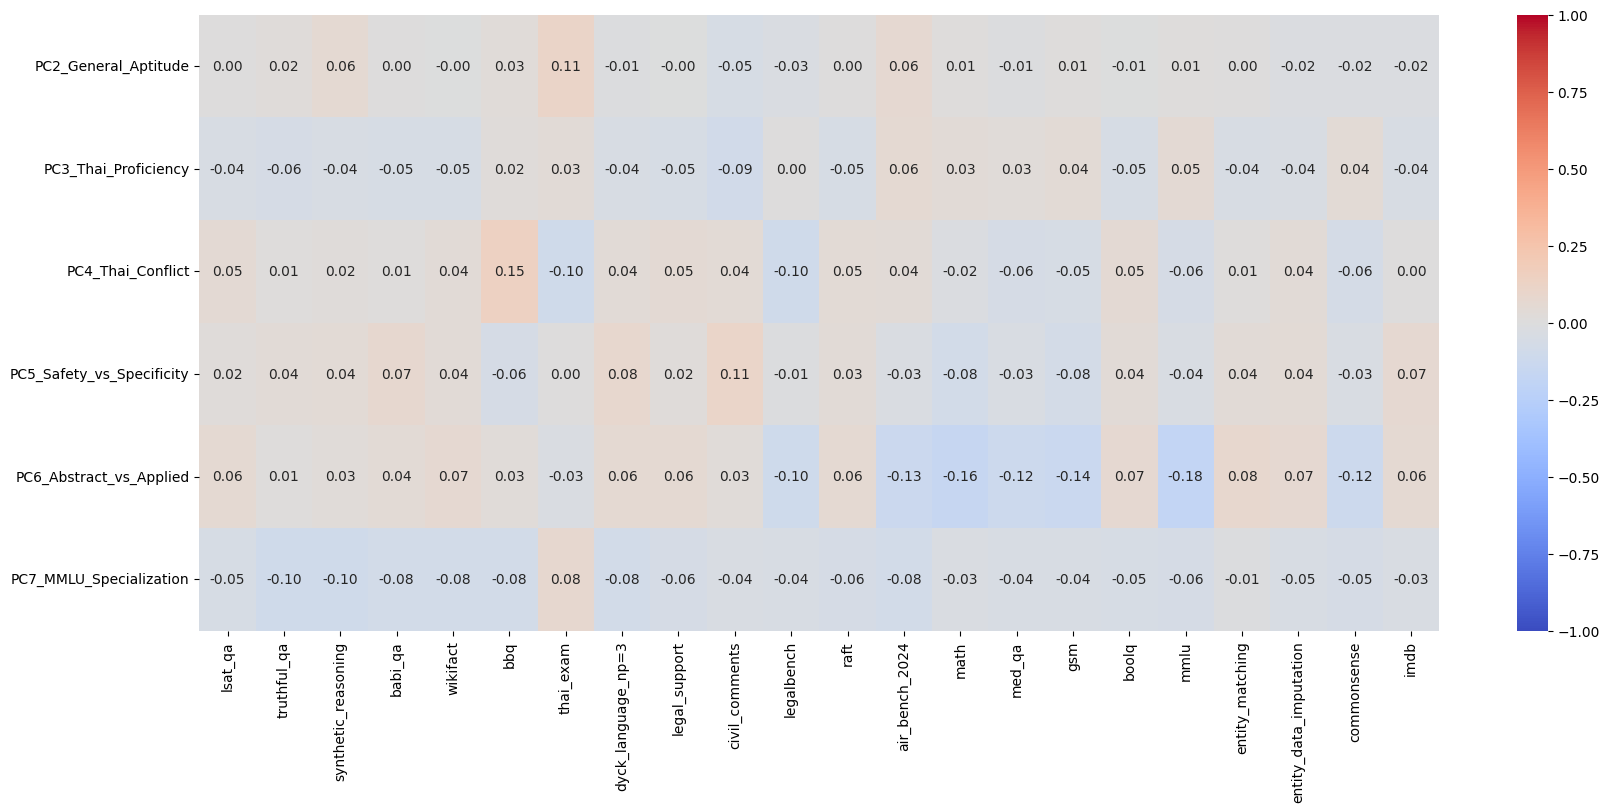

In [6]:
# Combine the two dataframes
combined_df = pd.concat([thetas_df, score_matrix_df], axis=1)

# Calculate the full correlation matrix
full_corr_matrix = combined_df.corr()

# Isolate the part of the matrix we care about:
# Rows: Your 6 test scores
# Columns: The 22 original dataset scores
validity_matrix = full_corr_matrix.loc[thetas_df.columns, score_matrix_df.columns]

# Plot the validity matrix as a heatmap
plt.figure(figsize=(20, 8))
sns.heatmap(validity_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.savefig('../result/PCA_testscore_corr.png')
plt.show()

--- Calculating Raw Sub-scores for 6 Components ---

Successfully created the raw sub-score matrix. Preview:
   PC2_General_Aptitude  PC3_Thai_Proficiency  PC4_Thai_Conflict  \
0                  0.00                  0.00               0.45   
1                  0.00                  0.05               0.00   
2                  0.00                  0.00               0.00   
3                  0.65                  0.00               0.00   
4                  0.00                  0.00               0.20   

   PC5_Safety_vs_Specificity  PC6_Abstract_vs_Applied  PC7_MMLU_Specialization  
0                       0.45                      0.1                     0.00  
1                       0.05                      0.0                     0.00  
2                       0.00                      0.0                     0.00  
3                       0.00                      0.0                     0.85  
4                       0.20                      0.0                     0.0

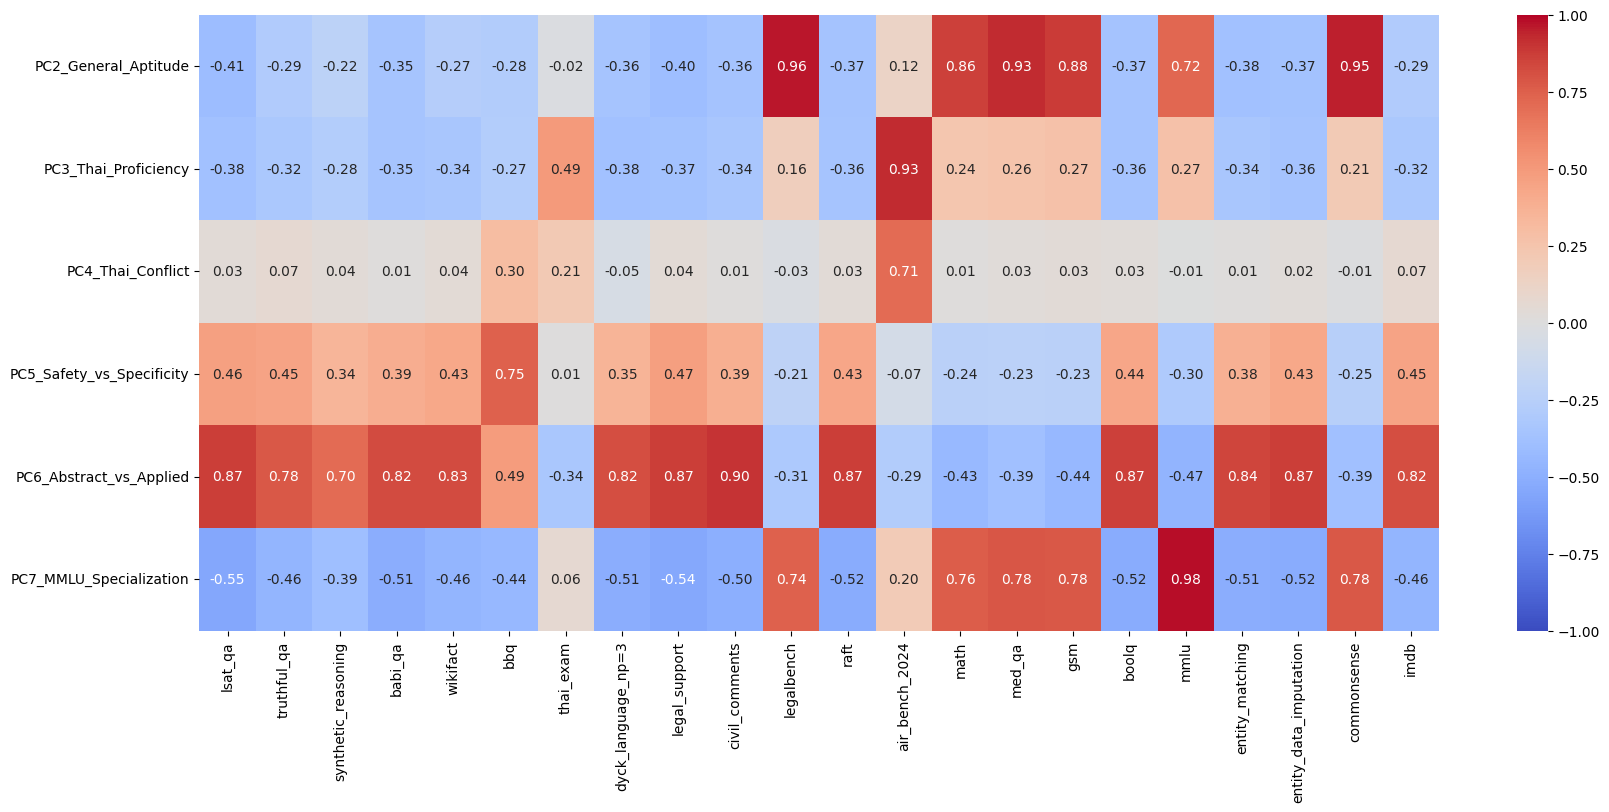

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ====================================================================================
# 1. Calculate Raw Sub-scores for 6 Components
# ====================================================================================
print("--- Calculating Raw Sub-scores for 6 Components ---")

component_names = master_test_df['component'].unique()
raw_subscores = {}

for component_name in component_names:
    # Get the sub-DataFrame for all items belonging to the current component
    component_metadata = master_test_df[master_test_df['component'] == component_name]
    
    # <<< FIX: Get the NEW indices (0-119) from the index of the metadata DataFrame >>>
    new_column_indices = component_metadata.index.tolist()
    
    # Use these new, correct indices to select columns from the NumPy array
    component_data = final_test_data_matrix[:, new_column_indices]
    
    # The .mean(axis=1) method works the same for NumPy arrays.
    raw_subscores[component_name] = component_data.mean(axis=1)

# Create the final (183, 6) DataFrame of raw sub-scores
raw_subscores_df = pd.DataFrame(raw_subscores)

print("\nSuccessfully created the raw sub-score matrix. Preview:")
print(raw_subscores_df.head())


# ====================================================================================
# 2. Run External Validity Analysis on Raw Sub-scores
# ====================================================================================
print("\n--- Running External Validity Analysis ---")

# Combine your new sub-scores with the original dataset scores
combined_df = pd.concat([raw_subscores_df, score_matrix_df], axis=1)

# Calculate the full correlation matrix
full_corr_matrix = combined_df.corr()

# Isolate the part of the matrix we care about:
# Rows: Your 6 new raw sub-scores
# Columns: The 22 original dataset scores
validity_matrix = full_corr_matrix.loc[raw_subscores_df.columns, score_matrix_df.columns]

# Plot the validity matrix as a heatmap
plt.figure(figsize=(20, 8))
sns.heatmap(validity_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.savefig('../result/PCA_subscore_corr.png')
plt.show()

# G-factor testing

In [8]:
import torch
import pandas as pd
import numpy as np
from torch.distributions import Bernoulli
from torch.optim import LBFGS
from tqdm import tqdm
import pingouin as pg
import gc

device = "cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"


master_test_df = pd.read_csv("../data/master_test_metadata.csv")
final_test_data_matrix = pd.read_pickle("../data/master_test_data_matrix.pkl").values
dtype = torch.float64 if device.startswith("cuda") else torch.float32
final_test_data_matrix = np.nan_to_num(final_test_data_matrix, nan=0)

# <<< CHANGE 1: Set dimensions to 7 (1 general + 6 specific) >>>
data_with0 = torch.tensor(final_test_data_matrix, device=device, dtype=torch.float32)
n_test_takers, n_items = data_with0.shape
n_dimensions = 7

# <<< Build the 7-Dimension Bi-factor Q-Matrix >>>
print("--- Building 7-Dimension Bi-factor Q-Matrix ---")
# First, create the 6 specific factor columns as before
specific_component_names = master_test_df['component'].unique()
Q_matrix_specific_df = pd.get_dummies(master_test_df['component'])
Q_matrix_specific_df = Q_matrix_specific_df[specific_component_names]

# Create the general factor column (all ones)
Q_matrix_specific_df['g_factor'] = 1

# Reorder columns to have the g-factor first
component_names = ['g_factor'] + list(specific_component_names)
Q_matrix_df = Q_matrix_specific_df[component_names]

# <<< FIX: Explicitly convert the DataFrame to an integer type before creating the tensor >>>
Q_matrix_df_numeric = Q_matrix_df.astype(int)

# Convert the now-guaranteed numeric data to a torch tensor
Q_matrix = torch.tensor(Q_matrix_df_numeric.values, device=device, dtype=torch.float32)

print(f"MASTER TEST specs: {n_test_takers} takers, {n_items} items, {n_dimensions} dimensions.")
print(f"Shape of new Bi-factor Q-Matrix: {Q_matrix.shape}")


# ====================================================================================
# 2. FIT THE 7-DIMENSION BI-FACTOR MIRT MODEL
# ====================================================================================
data_idtor = torch.ones_like(data_with0)
train_idtor = data_idtor

# --- STAGE 1: Fit Item Parameters (a_params and d_params) ---
print("\n--- Starting Stage 1: Fitting item parameters ---")
n_mc_samples = 150
thetas_nuisance = torch.randn(n_mc_samples, n_test_takers, n_dimensions, device=device)

a_params = torch.randn(n_items, n_dimensions, requires_grad=True, device=device)
ds = torch.randn(n_items, requires_grad=True, device=device)

# The model is small enough (120 items), so no batching is needed
optim_items = LBFGS([a_params, ds], lr=0.1, max_iter=50, history_size=10, line_search_fn="strong_wolfe")

def closure_items():
    optim_items.zero_grad()
    a_params_masked = a_params * Q_matrix
    a_params_constrained = torch.clamp(a_params_masked, min=1e-6)
    logits = torch.matmul(thetas_nuisance, a_params_constrained.T) - ds[None, None, :]
    probs = torch.sigmoid(logits)
    log_likelihoods = Bernoulli(probs=probs).log_prob(data_with0[None, :, :])
    loss = -log_likelihoods.sum() / (data_with0.numel() * n_mc_samples)
    loss.backward()
    return loss

optim_items.step(closure_items)

a_params_calibrated = a_params.detach()
ds_calibrated = ds.detach()
print("Stage 1 Finished.")

# --- STAGE 2: Fit Person Parameters (thetas) ---
print("\n--- Starting Stage 2: Fitting person parameters ---")
thetas = torch.randn(n_test_takers, n_dimensions, requires_grad=True, device=device)
optim_thetas = LBFGS([thetas], lr=0.1, max_iter=50, history_size=10, line_search_fn="strong_wolfe")

def closure_thetas():
    optim_thetas.zero_grad()
    thetas_constrained = torch.clamp(thetas, min=0) 
    a_params_constrained = torch.clamp(a_params_calibrated * Q_matrix, min=1e-6)
    logits = torch.matmul(thetas_constrained, a_params_constrained.T) - ds_calibrated[None, :]
    probs = torch.sigmoid(logits)
    log_likelihoods = Bernoulli(probs=probs).log_prob(data_with0)
    loss = -log_likelihoods.sum() / data_with0.numel()
    loss.backward()
    return loss

optim_thetas.step(closure_thetas)

thetas_final = torch.clamp(thetas.detach(), min=0)
print("Stage 2 Finished. Final model is fit.")

# ====================================================================================
# 3. VALIDATE THE BI-FACTOR MODEL
# ====================================================================================
print("\n--- BI-FACTOR MODEL VALIDATION ---")

# --- Reliability (Cronbach's Alpha) ---
# This remains the same, as it checks the consistency of the 6 specific sub-tests.
# --- Reliability (Cronbach's Alpha) ---
print("\n1. Reliability (Cronbach's Alpha for each component):")
response_df = pd.DataFrame(data_with0.cpu().numpy(), columns=range(n_items))

for component_name in specific_component_names: # Loop through specific factors only
    # Get the indices of items for this component
    component_indices = master_test_df[master_test_df['component'] == component_name].index.tolist()
    
    # Extract the component data using indices
    component_data = response_df.iloc[:, component_indices]
    
    # Ensure all data is numeric and handle any potential issues
    component_data = component_data.astype(float)
    
    # Remove rows with any missing values
    component_data_clean = component_data.dropna()
    
    if component_data_clean.shape[0] < 2 or component_data_clean.shape[1] < 2:
        print(f"  - {component_name}: Cannot compute Alpha (insufficient data)")
        continue
    
    try:
        # Calculate Cronbach's Alpha
        alpha_results = pg.cronbach_alpha(data=component_data_clean)
        print(f"  - {component_name}: Alpha = {alpha_results[0]:.3f}")
    except Exception as e:
        print(f"  - {component_name}: Error computing Alpha: {str(e)}")

# --- Factorial Validity (Theta Correlations) ---
print("\n2. Internal Structure (7x7 Theta Correlation Matrix):")
thetas_df = pd.DataFrame(thetas_final.cpu().numpy(), columns=component_names)
theta_correlation_matrix = thetas_df.corr()
print(theta_correlation_matrix.round(3))
print("\nInterpretation: Expect low correlations between specific factors.")

--- Building 7-Dimension Bi-factor Q-Matrix ---
MASTER TEST specs: 183 takers, 120 items, 7 dimensions.
Shape of new Bi-factor Q-Matrix: torch.Size([120, 7])

--- Starting Stage 1: Fitting item parameters ---
Stage 1 Finished.

--- Starting Stage 2: Fitting person parameters ---
Stage 2 Finished. Final model is fit.

--- BI-FACTOR MODEL VALIDATION ---

1. Reliability (Cronbach's Alpha for each component):
  - PC2_General_Aptitude: Alpha = 0.966
  - PC3_Thai_Proficiency: Alpha = 0.930
  - PC4_Thai_Conflict: Alpha = 0.872
  - PC5_Safety_vs_Specificity: Alpha = 0.858
  - PC6_Abstract_vs_Applied: Alpha = 0.890
  - PC7_MMLU_Specialization: Alpha = 0.999

2. Internal Structure (7x7 Theta Correlation Matrix):
                           g_factor  PC2_General_Aptitude  \
g_factor                      1.000                 0.044   
PC2_General_Aptitude          0.044                 1.000   
PC3_Thai_Proficiency         -0.109                -0.065   
PC4_Thai_Conflict             0.087         

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Your MASTER TEST scores (you should have this from the last script)
# It's a (183, 6) DataFrame with columns like 'PC2_General_Aptitude', etc.
thetas_df = pd.DataFrame(thetas_final.cpu().numpy(), columns=component_names)

# 2. The original dataset scores (re-create this if you don't have it loaded)
# This is the (183, 22) DataFrame you used for the PCA.
# conceptual code to re-create:
score_matrix_df = pd.read_csv("../data/scenario_probs.csv")

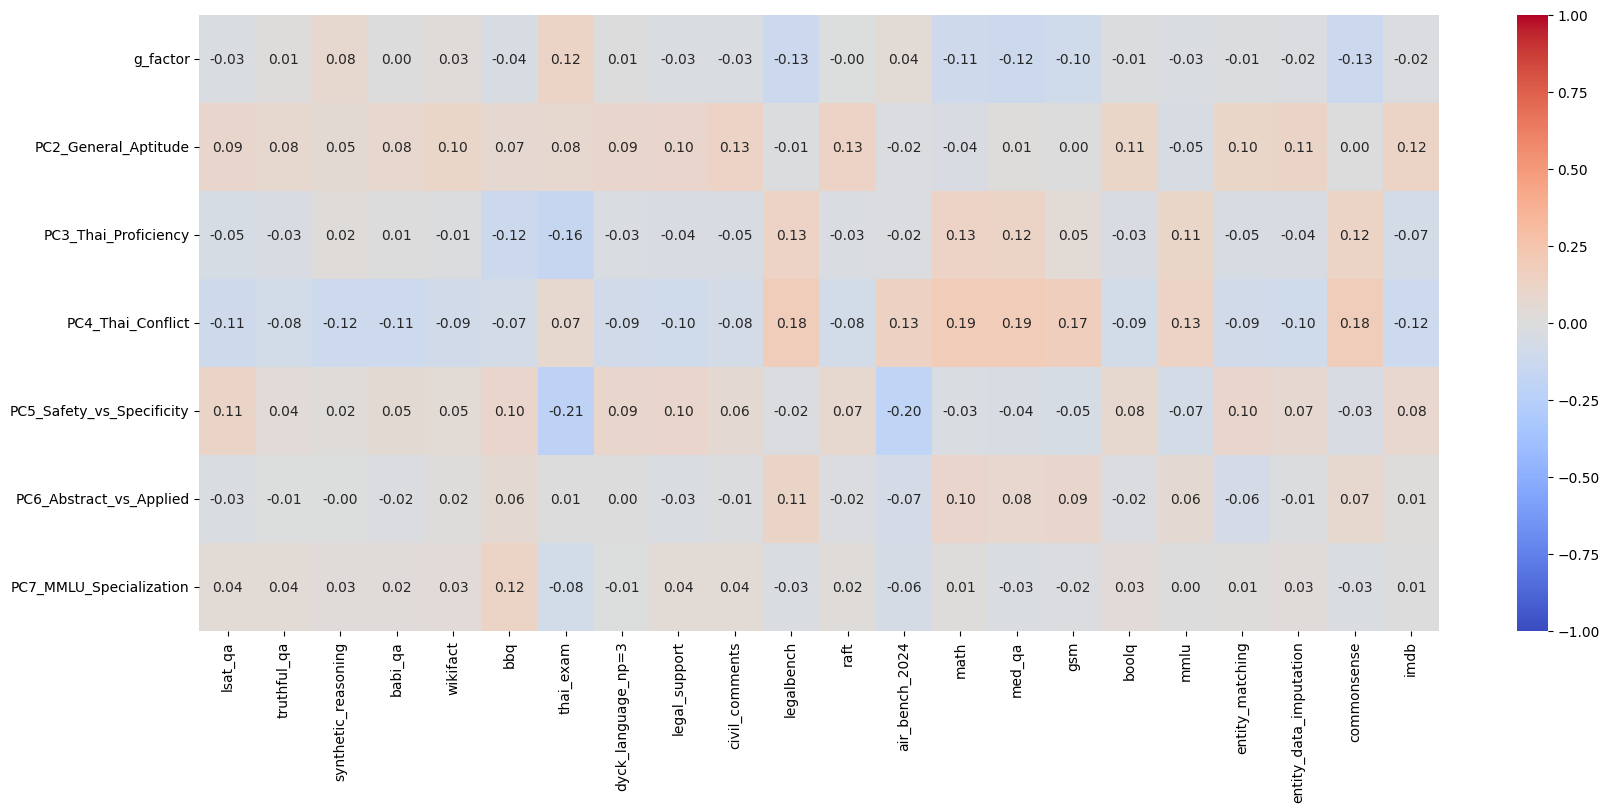

In [10]:
# Combine the two dataframes
combined_df = pd.concat([thetas_df, score_matrix_df], axis=1)

# Calculate the full correlation matrix
full_corr_matrix = combined_df.corr()

# Isolate the part of the matrix we care about:
# Rows: Your 6 test scores
# Columns: The 22 original dataset scores
validity_matrix = full_corr_matrix.loc[thetas_df.columns, score_matrix_df.columns]

# Plot the validity matrix as a heatmap
plt.figure(figsize=(20, 8))
sns.heatmap(validity_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.savefig('../result/PCA_g_testscore_corr.png')
plt.show()